New attempt to identify snow-atmosphere interface from SIMBA by comparing to (corrected) skin temperature when there's little to no incoming SW.

In [1]:
import matplotlib.pyplot as plt
import datetime, time, math, cmocean, csv
import numpy as np
from netCDF4 import Dataset
from scipy import interpolate
from astropy.convolution import convolve, convolve_fft
import glob
import matplotlib as mpl
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

In [2]:
def load_netcdf(filepath, in_vars):
    """ open netcdf file, load variables (in_vars should be a list) and
        output dictionary of variables"""

    out_vars = {}

    open_netcdf = Dataset(filepath, mode = 'r')
    if len(in_vars)>0:
        for var in in_vars:
            out_vars[var] = open_netcdf.variables[var][:]
    else:
        for var in open_netcdf.variables.keys():
            out_vars[var] = open_netcdf.variables[var][:]

    try:
        out_vars['time_unit'] = open_netcdf.variables['time'].units
    except:
        None
    open_netcdf.close()

    return out_vars

In [3]:
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

#### Load data for SIMBA and SLEIGH

In [4]:
# turn into function later?
asfs_filepath = '/psd3data/arctic/raven_process/asfs/2_level_product/'
asfs_lev2_files = glob.glob(asfs_filepath+'seb.level2.0.melt-sleighsfs.10min.*.nc')
asfs_lev2_files.sort()

## don't actually need all these variables, but sometimes it's nice to have other variables to compare to
lev1_slow_vars = ['up_short_hemisp_qc','up_long_hemisp_qc','down_short_hemisp_qc','down_long_hemisp_qc','subsurface_heat_flux_A_qc',
                  'subsurface_heat_flux_B_qc','skin_temp_surface_qc','temp_qc','snow_depth_qc','zenith_true_qc',
                  'down_short_diffuse','down_short_direct','up_short_hemisp','up_long_hemisp','down_short_hemisp','down_long_hemisp',
                  'snow_depth','temp','brightness_temp_surface','subsurface_heat_flux_A','subsurface_heat_flux_B',
                  'subsurface_heat_flux_C','base_time','time']

asfs_data_lev2 = {}

for fname in asfs_lev2_files[:]:
    print(fname)

    fdic = load_netcdf(fname, lev1_slow_vars)
    # print(fdic['time_unit'])
    fstart_time = datetime.datetime.strptime(fdic['time_unit'], 'seconds since %Y-%m-%dT%H:%M:%S.000000')
    fdic['dates'] = np.asarray([fstart_time+datetime.timedelta(seconds=int(m)) for m in fdic['time']])

    for var in lev1_slow_vars[:-2]+['dates']:
        if var not in asfs_data_lev2:
            asfs_data_lev2[var] = fdic[var]
        else:
            asfs_data_lev2[var] = np.ma.concatenate( (asfs_data_lev2[var], fdic[var]), axis=0 )

## corrected skin temperature
# same time steps as asfs_data_lev2['dates']
with np.load('/home/asledd/ICECAPS/Raven_SW-correct-tskin_emis985_all-times_20250113.npz') as npz:
    asfs_data_lev2['skin_temp_corrected'] =  np.ma.MaskedArray(**npz)

/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240520.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240521.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240522.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240523.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240524.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240525.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240526.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240527.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240528.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb

In [5]:
## try opening all SIMBA files
# turn into function later?
simba_filepath = '/psd3data/arctic/raven/simba/level1/'

lev1_files = glob.glob(simba_filepath+'*.nc')
lev1_files.sort()

## get rid of march files, will also probably want to get rid of first few days of actual data after install as well?
lev1_files = lev1_files[5:] ## michael deleted march files? but they're still showing up?

varnames = ['temperature','height','time']

season_data = {}

for fname in lev1_files[:]:
    fdic = load_netcdf(fname, varnames)
    print(fname)
    fstart_time = datetime.datetime.strptime(fdic['time_unit'][-19:], '%Y-%m-%d %H:%M:%S')
    fdic['dates'] = np.asarray([fstart_time+datetime.timedelta(minutes=int(m)) for m in fdic['time']])

    for var in ['temperature','dates']:
        if var not in season_data:
            season_data[var] = fdic[var]
        else:
            season_data[var] = np.ma.concatenate( (season_data[var], fdic[var]), axis=0 )

    ## only want one height:
    if 'height' not in season_data:
        season_data['height'] = fdic['height']
    # print(season_data['dates'].shape, season_data['height'].shape, season_data['temperature'].shape)

/psd3data/arctic/raven/simba/level1/firnprofile.sled.level1.15min.20240513.000000.nc
/psd3data/arctic/raven/simba/level1/firnprofile.sled.level1.15min.20240514.000000.nc
/psd3data/arctic/raven/simba/level1/firnprofile.sled.level1.15min.20240515.000000.nc
/psd3data/arctic/raven/simba/level1/firnprofile.sled.level1.15min.20240516.000000.nc
/psd3data/arctic/raven/simba/level1/firnprofile.sled.level1.15min.20240517.000000.nc
/psd3data/arctic/raven/simba/level1/firnprofile.sled.level1.15min.20240518.000000.nc
/psd3data/arctic/raven/simba/level1/firnprofile.sled.level1.15min.20240519.000000.nc
/psd3data/arctic/raven/simba/level1/firnprofile.sled.level1.15min.20240520.000000.nc
/psd3data/arctic/raven/simba/level1/firnprofile.sled.level1.15min.20240521.000000.nc
/psd3data/arctic/raven/simba/level1/firnprofile.sled.level1.15min.20240522.000000.nc
/psd3data/arctic/raven/simba/level1/firnprofile.sled.level1.15min.20240523.000000.nc
/psd3data/arctic/raven/simba/level1/firnprofile.sled.level1.15min

Need to interpolate SLEIGH time to SIMBA time for SW and skin temp

In [6]:
sleigh_seconds = np.asarray([(t-datetime.datetime(1970,1,1)).total_seconds() for t in asfs_data_lev2['dates']])
simba_seconds = np.asarray([(t-datetime.datetime(1970,1,1)).total_seconds() for t in season_data['dates']])

print(sleigh_seconds.shape)

interpolated_sleigh_vars = {}
varnames = ['down_short_hemisp','skin_temp_corrected']

for varname in varnames:
    var_data = asfs_data_lev2[varname]
    print(varname, var_data.shape)
    f_0 = interpolate.interp1d(sleigh_seconds[~var_data.mask], var_data[~var_data.mask], fill_value='extrapolate')
    interpolated_sleigh_vars[varname] = f_0(simba_seconds)

(12384,)
down_short_hemisp (12384,)
skin_temp_corrected (12384,)


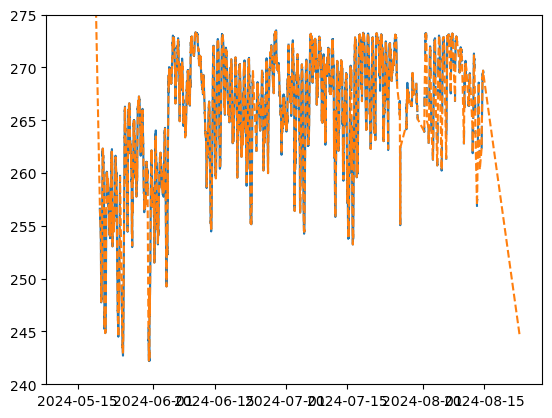

In [7]:
varname = 'skin_temp_corrected'
plt.plot(asfs_data_lev2['dates'], asfs_data_lev2[varname])
plt.plot(season_data['dates'], interpolated_sleigh_vars[varname], ls='--')
plt.ylim(240,275)
plt.show()

Test if idea is plausible by comparing some temperature profiles at night to skin temperature

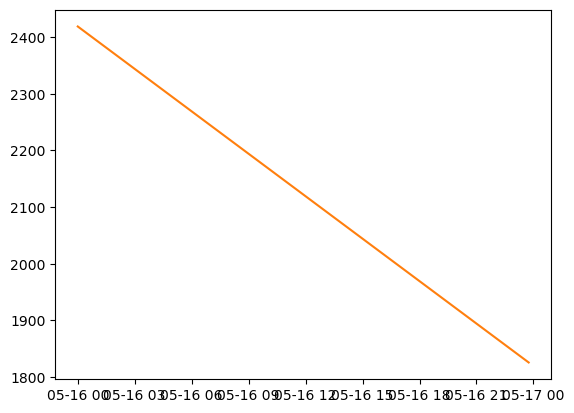

0


In [60]:
date = datetime.datetime(2024, 5, 16)
date_idx = np.where((season_data['dates']>=date)&(season_data['dates']<date+datetime.timedelta(days=1)))[0]

date_idx_sleigh = np.where((asfs_data_lev2['dates']>=date)&(asfs_data_lev2['dates']<date+datetime.timedelta(days=1)))[0]

plt.plot(asfs_data_lev2['dates'][date_idx_sleigh], asfs_data_lev2['down_short_hemisp'][date_idx_sleigh])
plt.plot(season_data['dates'][date_idx],interpolated_sleigh_vars['down_short_hemisp'][date_idx])
plt.show()

print( len(np.where(interpolated_sleigh_vars['down_short_hemisp'][date_idx]<1)[0] ))

at install thermistor #100 and #180 were at the surface; #150 was off the upper support wood, as in it's the top of the profile into the snow; #80 and #160 were at the same height in the air

In [9]:
simba_height_idx = np.where( (season_data['height']>-400)&(season_data['height']<-270) )[0]

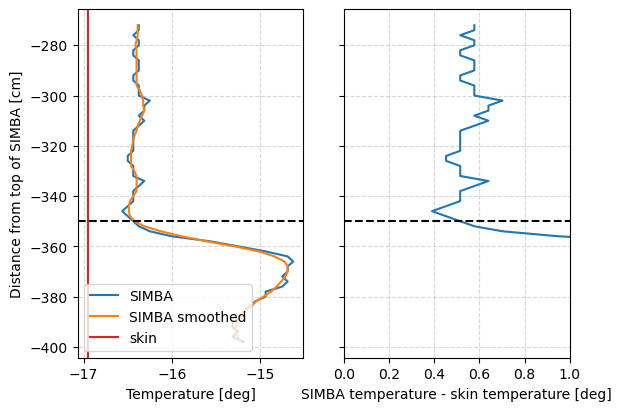

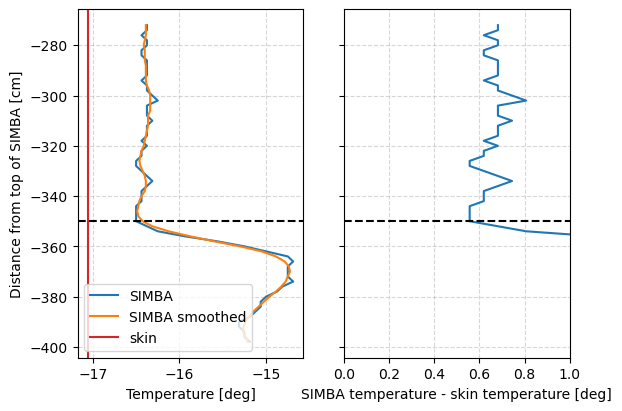

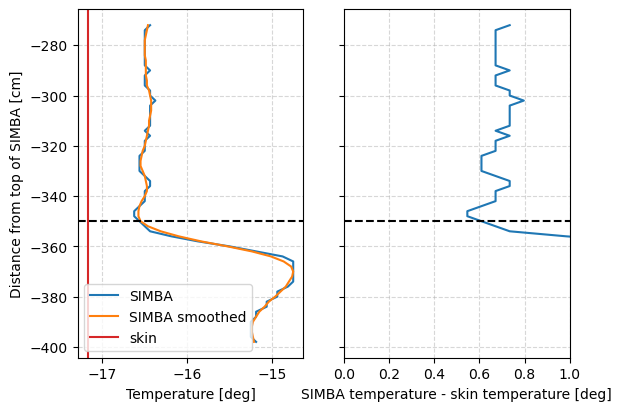

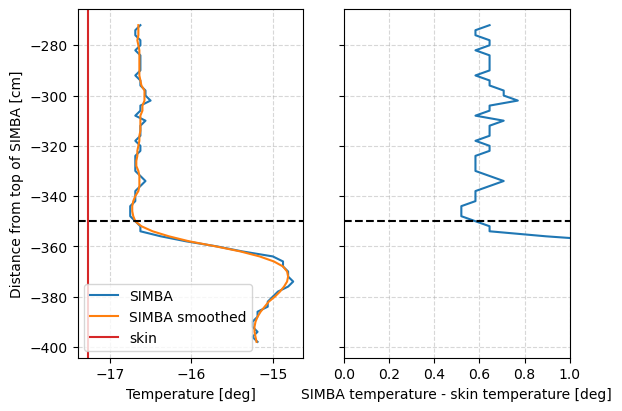

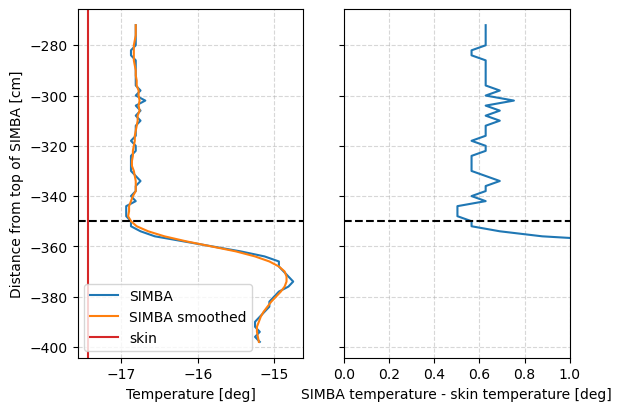

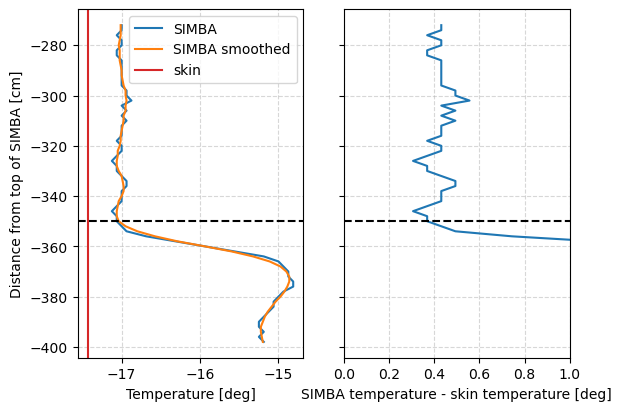

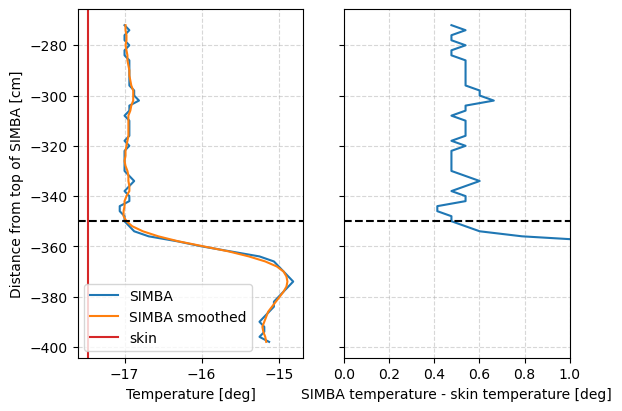

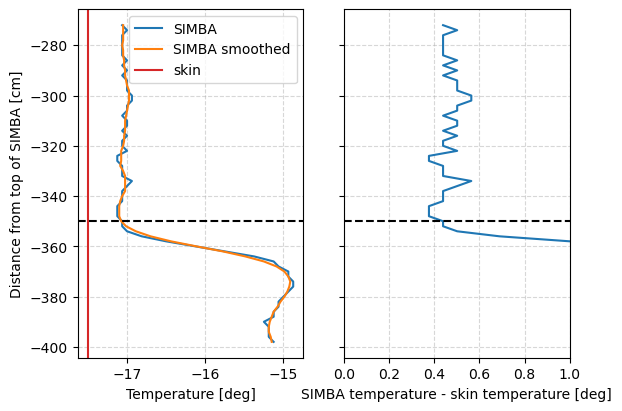

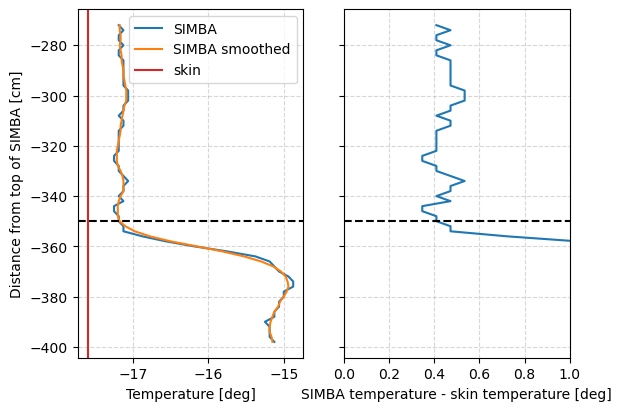

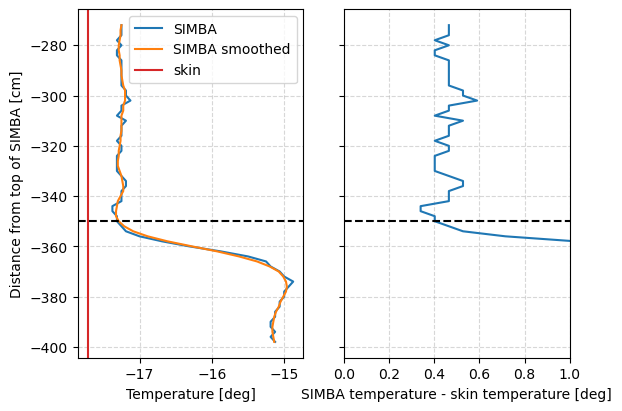

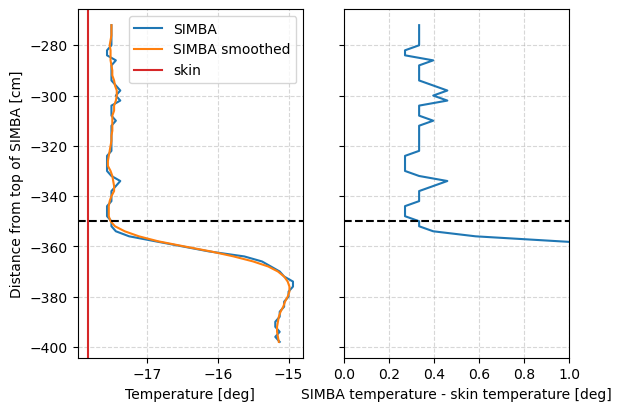

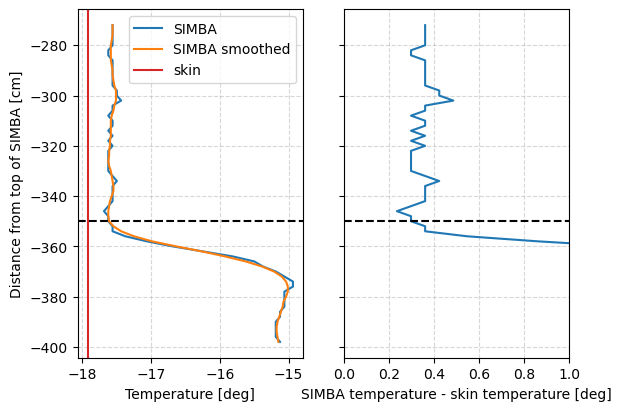

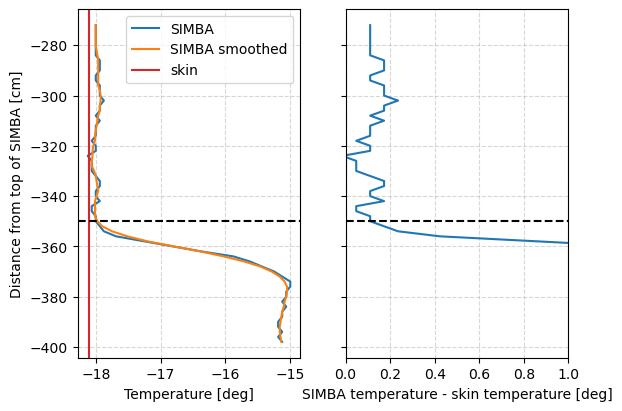

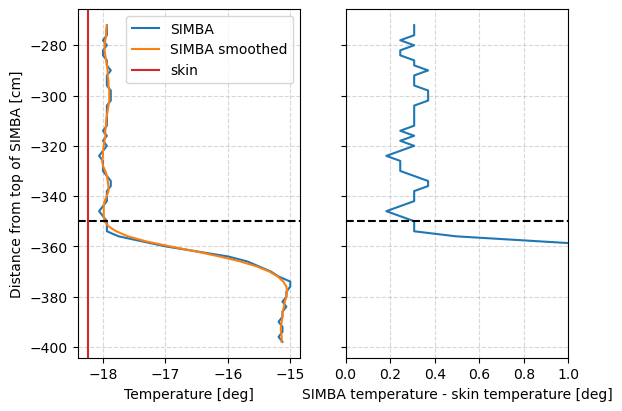

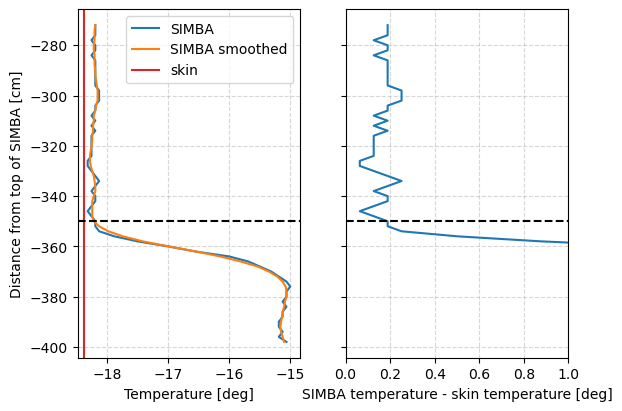

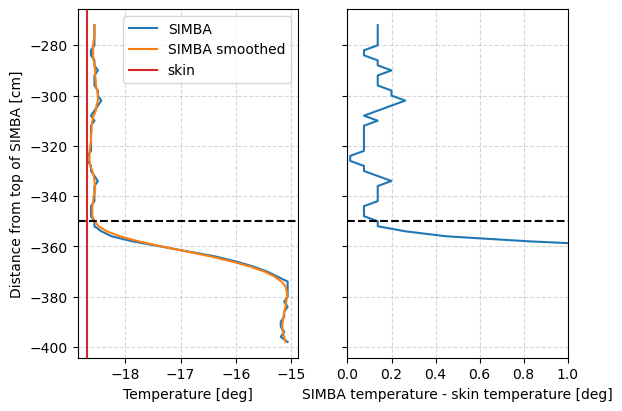

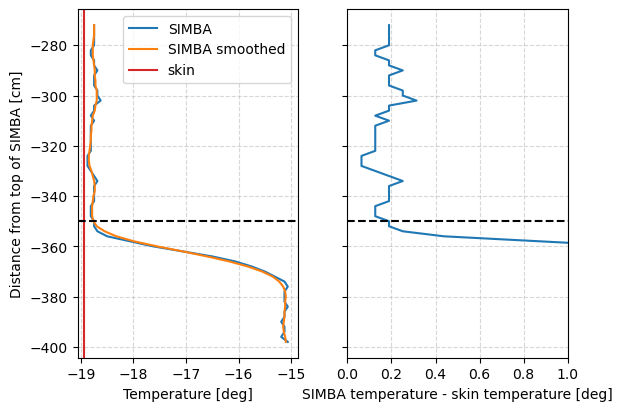

In [47]:
zero_sw_date_idx = np.where(interpolated_sleigh_vars['down_short_hemisp'][date_idx]<1)[0]
kernel_avg_10 = [1./(5)]*(5)

for idx in zero_sw_date_idx:
    fig, axs = plt.subplots(1,2, figsize=(6,4), sharey=True, constrained_layout=True)
    axs[0].plot(season_data['temperature'][date_idx,:][:,simba_height_idx][idx,:], season_data['height'][simba_height_idx], label='SIMBA')

    T_smoothed = convolve(season_data['temperature'][date_idx,:][:,simba_height_idx][idx,:], kernel_avg_10, boundary='extend')
    axs[0].plot(T_smoothed, season_data['height'][simba_height_idx], label='SIMBA smoothed')

    axs[0].axvline(x=interpolated_sleigh_vars['skin_temp_corrected'][date_idx][idx]-273.15, label='skin', c='tab:red')

    axs[1].plot(season_data['temperature'][date_idx,:][:,simba_height_idx][idx,:]-(interpolated_sleigh_vars['skin_temp_corrected'][date_idx][idx]-273.15),
               season_data['height'][simba_height_idx])
    
    axs[0].set_ylabel('Distance from top of SIMBA [cm]')
    axs[0].set_xlabel('Temperature [deg]')
    axs[1].set_xlabel('SIMBA temperature - skin temperature [deg]')
    axs[1].set_xlim(0,1)

    for ax in axs.ravel():
        ax.grid(alpha=.5, ls='--')
        ax.axhline(y=-175*2, c='k', ls='--')
    axs[0].legend(loc='best')
    plt.show()

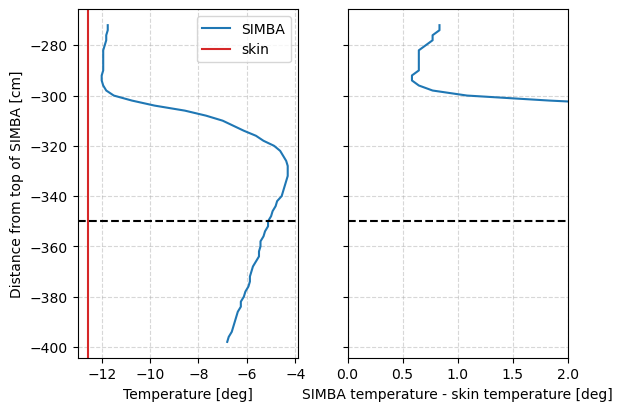

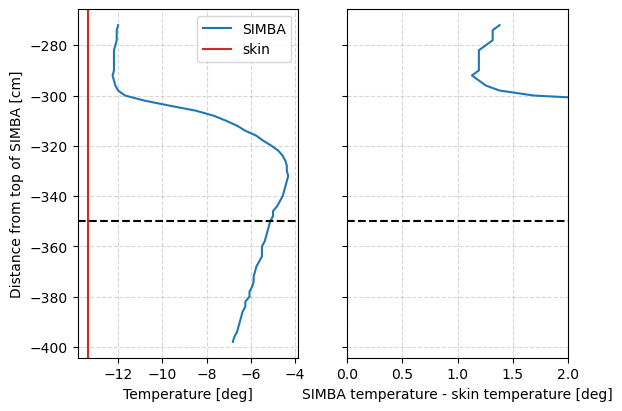

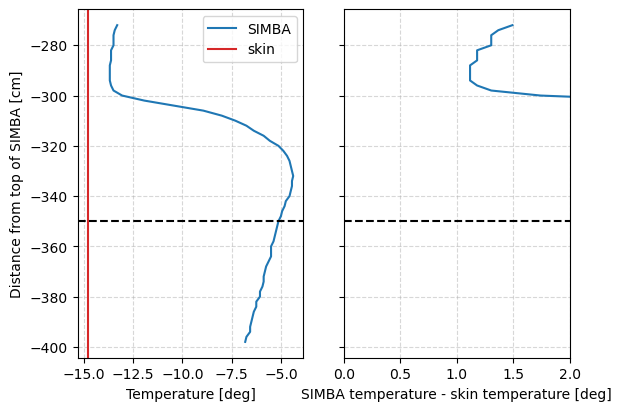

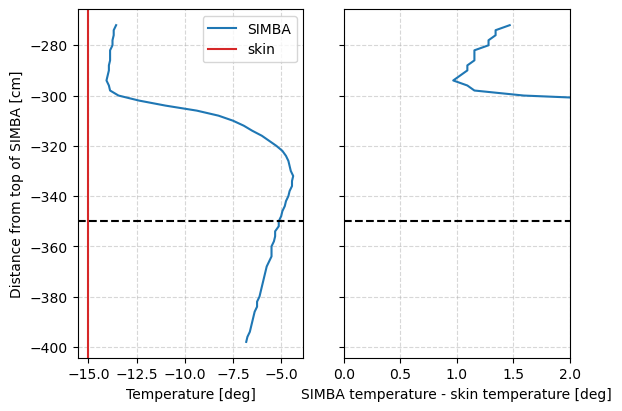

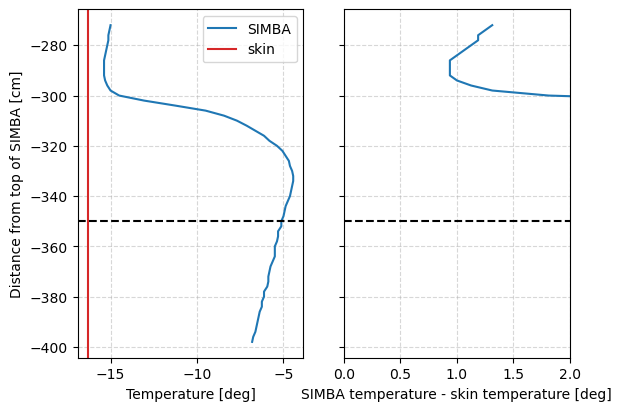

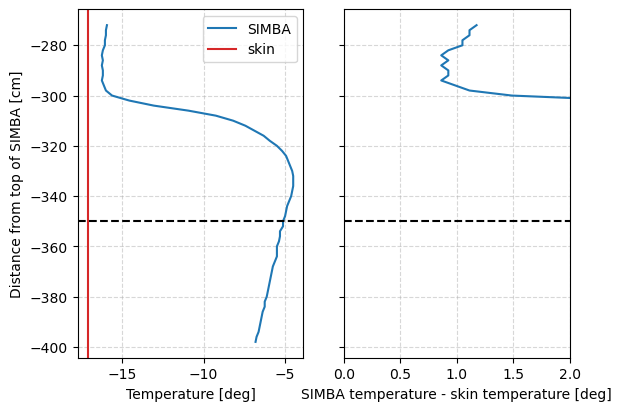

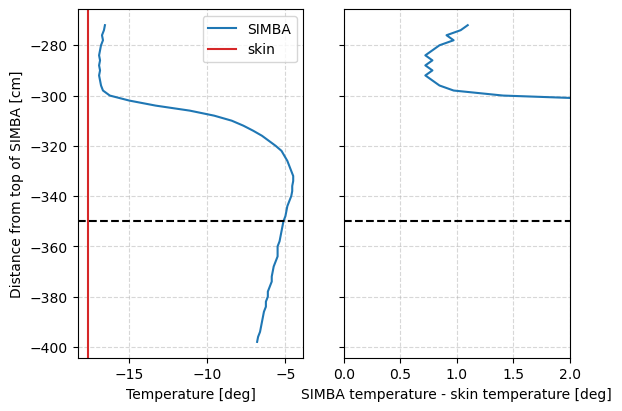

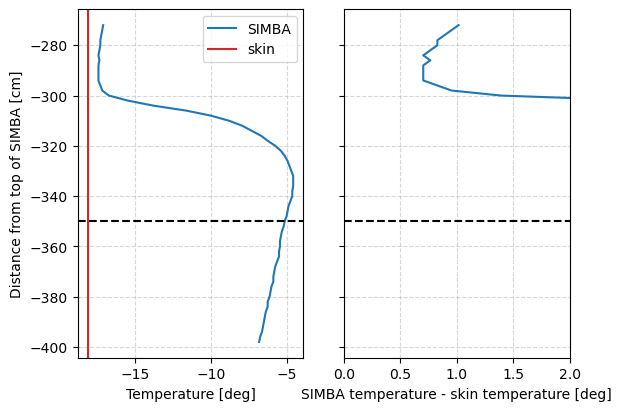

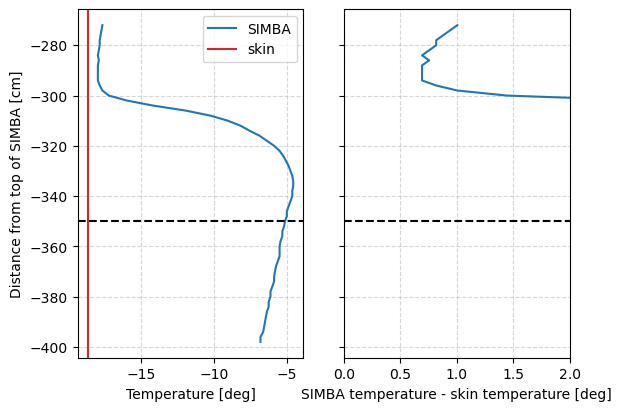

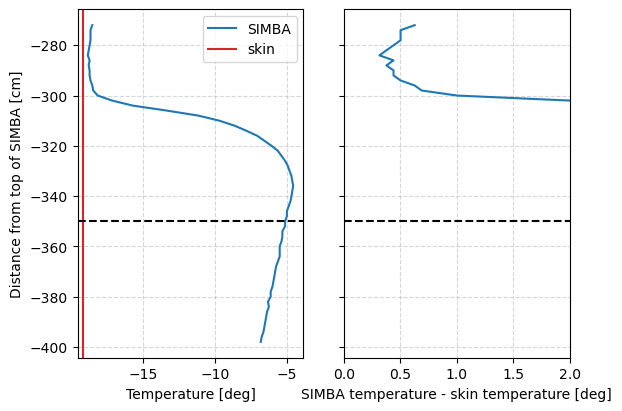

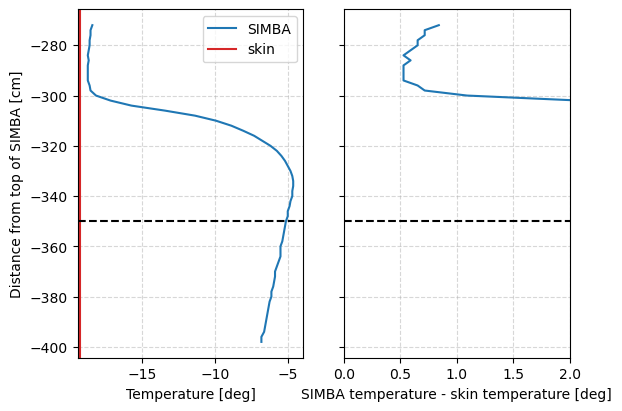

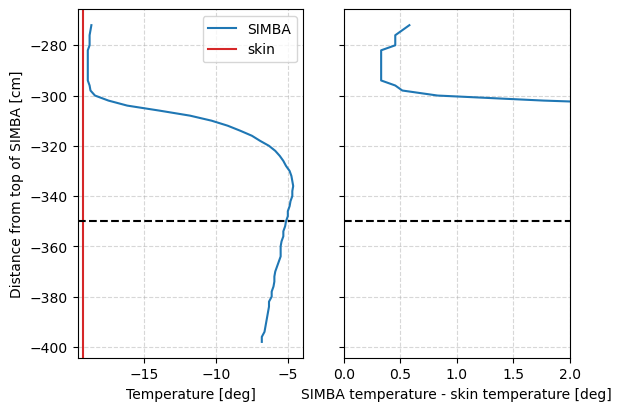

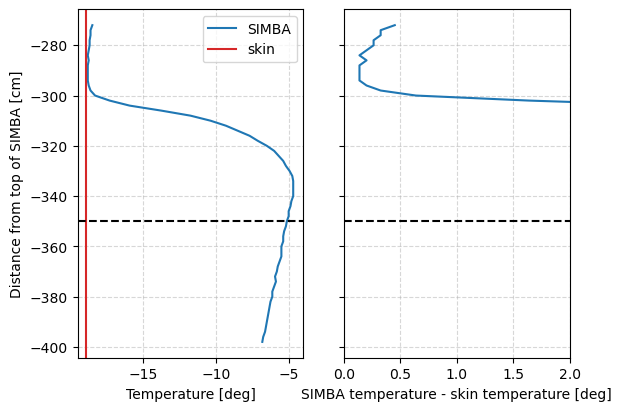

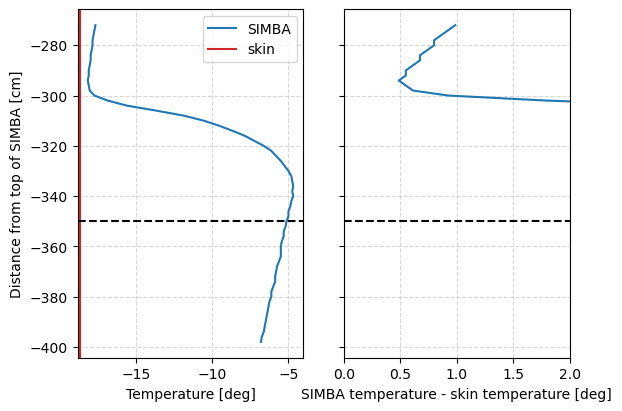

In [52]:
date = datetime.datetime(2024, 7, 15)
date_idx = np.where((season_data['dates']>=date)&(season_data['dates']<date+datetime.timedelta(days=1)))[0]

zero_sw_date_idx = np.where(interpolated_sleigh_vars['down_short_hemisp'][date_idx]<1)[0]

for idx in zero_sw_date_idx:
    fig, axs = plt.subplots(1,2, figsize=(6,4), sharey=True, constrained_layout=True)
    axs[0].plot(season_data['temperature'][date_idx,:][:,simba_height_idx][idx,:], season_data['height'][simba_height_idx], label='SIMBA')
    axs[0].axvline(x=interpolated_sleigh_vars['skin_temp_corrected'][date_idx][idx]-273.15, label='skin', c='tab:red')

    axs[1].plot(season_data['temperature'][date_idx,:][:,simba_height_idx][idx,:]-(interpolated_sleigh_vars['skin_temp_corrected'][date_idx][idx]-273.15),
               season_data['height'][simba_height_idx])
    
    axs[0].set_ylabel('Distance from top of SIMBA [cm]')
    axs[0].set_xlabel('Temperature [deg]')
    axs[1].set_xlabel('SIMBA temperature - skin temperature [deg]')
    axs[1].set_xlim(0,2)

    for ax in axs.ravel():
        ax.grid(alpha=.5, ls='--')
        ax.axhline(y=-175*2, c='k', ls='--')
    axs[0].legend(loc='best')
    plt.show()

Just use minimum temperature when SW is <1 Wm-2?

In [13]:
## limit the range of where we're looking for interface
sfc_id_height_idx = np.where( (season_data['height']>-380)&(season_data['height']<-270) )[0]
heights_subset = season_data['height'][sfc_id_height_idx]

In [77]:
## give some rough estimates/bounds of where you expect the surface to be
## cuts down on noise
array_dates = np.asarray(season_data['dates'])
upper_guess = np.full(season_data['temperature'].shape[0], -340)
upper_guess[np.where((array_dates>datetime.datetime(2024,5,25))&(array_dates<datetime.datetime(2024,6,6)))[0]] = -330
upper_guess[np.where((array_dates>=datetime.datetime(2024,6,6))&(array_dates<=datetime.datetime(2024,6,25)))[0]] = -315
upper_guess[np.where((array_dates>datetime.datetime(2024,6,25))&(array_dates<=datetime.datetime(2024,7,30)))[0]] = -290

lower_guess = np.full(season_data['temperature'].shape[0], -360)
lower_guess[np.where((array_dates>datetime.datetime(2024,5,25))&(array_dates<=datetime.datetime(2024,6,25)))[0]] = -360
lower_guess[np.where((array_dates>datetime.datetime(2024,6,25))&(array_dates<=datetime.datetime(2024,7,30)))[0]] = -310

## specific for isothermal times
lower_guess[np.where((array_dates>datetime.datetime(2024,6,4))&(array_dates<=datetime.datetime(2024,6,12)))[0]] = -340
lower_guess[np.where((array_dates>datetime.datetime(2024,6,4))&(array_dates<=datetime.datetime(2024,6,12)))[0]] = -340

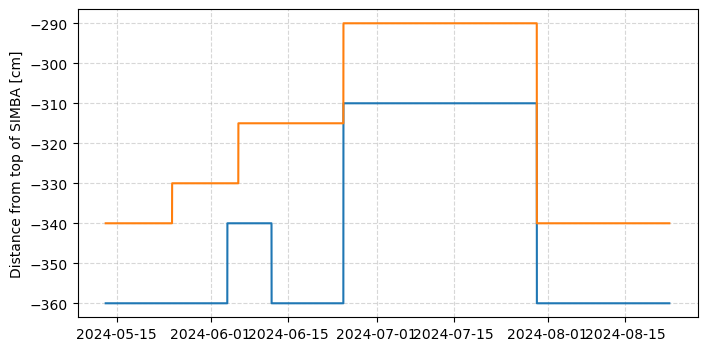

In [78]:
fig, ax= plt.subplots(1, figsize=(8,4))

plt.plot(array_dates, lower_guess)
plt.plot(array_dates, upper_guess)
plt.ylabel('Distance from top of SIMBA [cm]')
plt.grid(alpha=.5, ls='--')
# fig.savefig('/home/asledd/ICECAPS/sfc_id_figures/SIMBA_sfc-id_method-bounds.png', dpi=250)

Smooth surface id after? take average of values w/in low-sw time of each day?

In [101]:
sfc_id = []
sfc_id_dates = []
sfc_id_smoothed = []
sfc_id_smoothed_dates = []

kernel_avg_3 = [1./(3)]*(3)

for i in range(season_data['temperature'].shape[0]):
    
    if interpolated_sleigh_vars['down_short_hemisp'][i]>1:
        # sfc_id.append(np.nan)
        # print('No SW<1',season_data['dates'][i], interpolated_sleigh_vars['down_short_hemisp'][i])
        continue

    temp_subset = season_data['temperature'][i][sfc_id_height_idx]
    temp_subset_smoothed = convolve(temp_subset, kernel_avg_3, boundary='extend')


    temp_subset = np.ma.masked_where(heights_subset>upper_guess[i], temp_subset)
    temp_subset = np.ma.masked_where(heights_subset<lower_guess[i], temp_subset)

    temp_subset_smoothed = np.ma.masked_where(heights_subset>upper_guess[i], temp_subset_smoothed)
    temp_subset_smoothed = np.ma.masked_where(heights_subset<lower_guess[i], temp_subset_smoothed)

    min_idx = np.ma.where(temp_subset==temp_subset.min())[0]
    min_idx_smoothed = np.ma.where(temp_subset_smoothed==temp_subset_smoothed.min())[0]

    print(temp_subset_smoothed.min())
    if min_idx_smoothed.size!=0:
        if len(min_idx_smoothed)>1:
            min_idx_smoothed = min_idx_smoothed[0]
        sfc_id_smoothed.append(np.squeeze(heights_subset[min_idx_smoothed]))
        
    if np.shape(min_idx)[0]>1:
        # print(min_idx)
        min_idx = min_idx[0]
 
    elif min_idx.size==0:
        continue
    print(min_idx_smoothed)
    # print()
    sfc_id.append(np.squeeze(heights_subset[min_idx]))
    sfc_id_dates.append(season_data['dates'][i])

    
    # fig, ax = plt.subplots(1, figsize=(6,4))
    # ax.plot(season_data['temperature'][:,simba_height_idx][idx,:], heights_subset, label='SIMBA')
    # # ax.axvline(x=interpolated_sleigh_vars['skin_temp_corrected'][date_idx][idx]-273.15, label='skin', c='tab:red')

    
    # ax.set_ylabel('Distance from top of SIMBA [cm]')
    # ax.set_xlabel('Temperature [deg]')

    # ax.grid(alpha=.5, ls='--')
    # ax.axhline(y=heights_subset[min_idx], c='r', ls='--')
    # # axs[0].legend(loc='best')
    # plt.show()
print( len(sfc_id_smoothed), len(sfc_id))

-16.520833333333332
[37]
-16.5
37
-16.604166666666664
37
-16.75
[37]
-16.9375
[37]
-17.083333333333332
37
-17.041666666666664
[37]
-17.125
[37]
-17.229166666666664
[37]
-17.354166666666664
[37]
-17.5625
[37]
-17.645833333333332
37
-18.041666666666664
[37]
-18.020833333333332
[37]
-18.270833333333332
[37]
-18.625
[37]
-18.8125
[37]
-26.270833333333332
37
-26.499999999999996
[38]
-27.104166666666664
37
-27.375
[38]
-26.479166666666664
39
-26.229166666666664
39
-25.875
[39]
-25.25
39
-25.937499999999996
[39]
-25.354166666666664
40
-25.583333333333332
[40]
-25.916666666666664
38
-25.833333333333332
[39]
-25.875
38
-26.25
38
-26.375
38
-26.416666666666664
37
-15.8125
[37]
-16.416666666666664
[37]
-16.3125
[37]
-16.520833333333332
[37]
-16.833333333333332
[37]
-17.229166666666664
[37]
-17.604166666666664
[37]
-17.083333333333332
[37]
-16.916666666666664
[37]
-17.479166666666664
[37]
-17.3125
[37]
-17.375
[37]
-17.854166666666664
[37]
-17.3125
[37]
-17.604166666666664
[37]
-17.854166666666664

In [17]:
## for plotting and comparing
dTdt = (season_data['temperature'][1:,:] - season_data['temperature'][:-1,:])#/(15.*60) # timesteps are 15 minutes
dTdz = (season_data['temperature'][:,1:] - season_data['temperature'][:,:-1])#/0.02 # vertical resolution is 2 cm

In [85]:
print(np.asarray(sfc_id_smoothed).shape)

(1115, 0)


In [104]:
## try smoothing sfc id
kernel_avg_6 = [1./(9)]*(9)
sfc_id_runmean = convolve(np.asarray(sfc_id), kernel_avg_6, boundary='extend')
sfc_id_smoothed_runmean = convolve(np.squeeze(np.asarray(sfc_id_smoothed)), kernel_avg_6, boundary='extend')

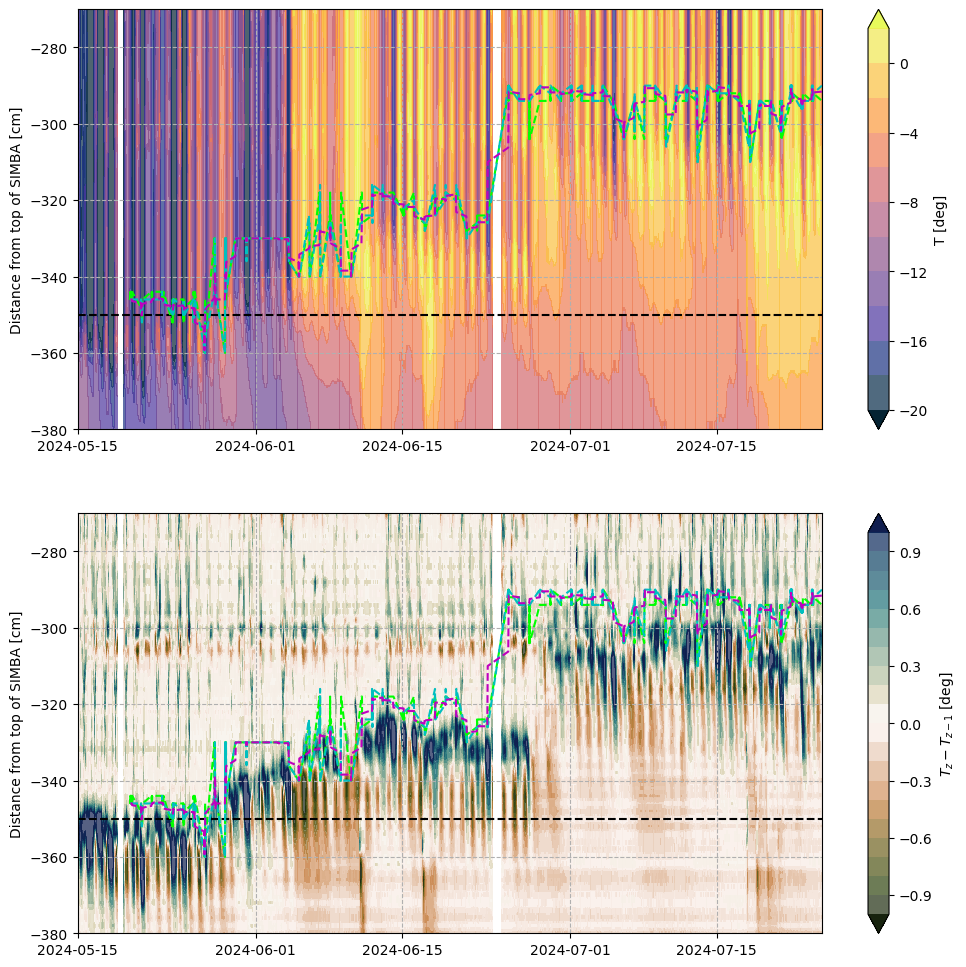

In [108]:

fig, axs = plt.subplots(2, figsize=(12,12), sharey=True)


cb = axs[0].contourf(season_data['dates'], season_data['height'], np.swapaxes(season_data['temperature'],0,1),
                cmap=cmocean.cm.thermal, levels=np.arange(-20,3,2), extend='both', alpha=.7)
plt.colorbar(cb, label='T [deg]', ax=axs[0])

cb = axs[1].contourf(season_data['dates'], season_data['height'][:-1], np.swapaxes(dTdz,0,1),
                cmap=cmocean.cm.tarn, levels=np.arange(-1,1.1,.1), extend='both', alpha=.7)
plt.colorbar(cb, label='$T_z-T_{z-1}$ [deg]', ax=axs[1])


axs[0].set_ylim(-380, -270) ## if you look at the full profile you can see when/where the surface accumulated along the rest of it

for ax in axs.ravel():
    ax.axhline(y=-350, c='k', ls='--') ## initial thermistor at the surface when the instrument was installed
    ax.plot(sfc_id_dates, sfc_id, c='lime', ls='--')
    ax.plot(sfc_id_dates, sfc_id_smoothed, c='c', ls='--')
    ax.plot(sfc_id_dates, sfc_id_smoothed_runmean, c='m', ls='--')

    ax.grid(ls='--')
    ax.set_ylabel('Distance from top of SIMBA [cm]')
    ax.set_xlim(datetime.datetime(2024,5,15), datetime.datetime(2024,7,25))
plt.show()

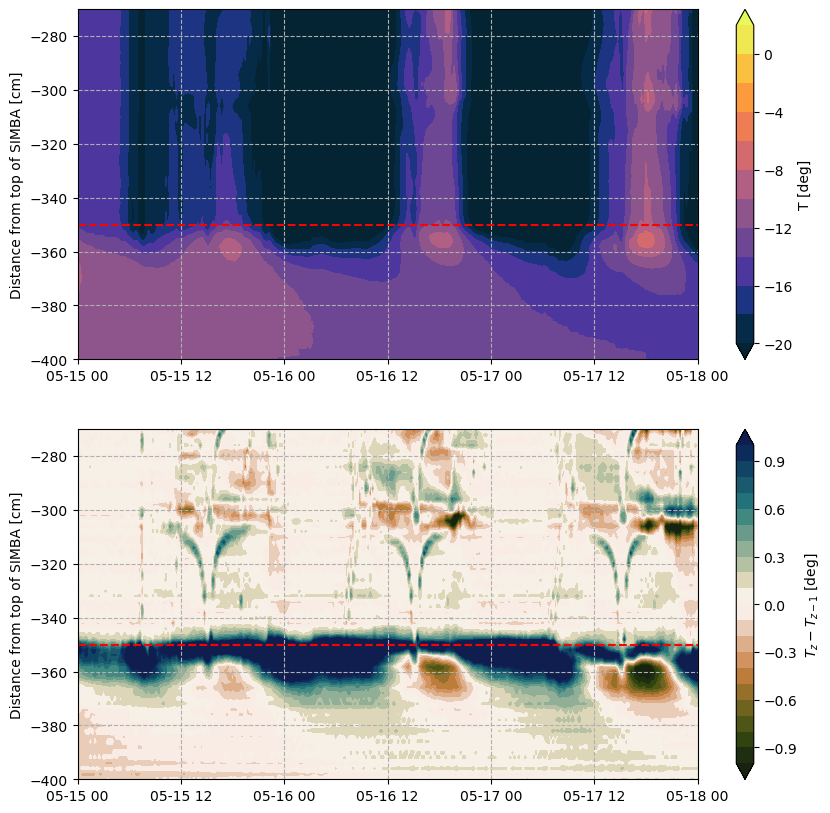

In [55]:

fig, axs = plt.subplots(2, figsize=(10,10), sharey=True)


cb = axs[0].contourf(season_data['dates'], season_data['height'], np.swapaxes(season_data['temperature'],0,1),
                cmap=cmocean.cm.thermal, levels=np.arange(-20,3,2), extend='both')
plt.colorbar(cb, label='T [deg]', ax=axs[0])

cb = axs[1].contourf(season_data['dates'], season_data['height'][:-1], np.swapaxes(dTdz,0,1),
                cmap=cmocean.cm.tarn, levels=np.arange(-1,1.1,.1), extend='both')
plt.colorbar(cb, label='$T_z-T_{z-1}$ [deg]', ax=axs[1])


axs[0].set_ylim(-400, -270) ## if you look at the full profile you can see when/where the surface accumulated along the rest of it

for ax in axs.ravel():
    ax.axhline(y=-350, c='r', ls='--') ## initial thermistor at the surface when the instrument was installed
    ax.plot(sfc_id_dates, sfc_id, c='lime', ls='--')
    ax.grid(ls='--')
    ax.set_ylabel('Distance from top of SIMBA [cm]')
    ax.set_xlim(datetime.datetime(2024,5,15), datetime.datetime(2024,5,18))
plt.show()

#### Compare different surface ID methods

In [123]:
with np.load('/home/asledd/ICECAPS/Raven_SIMBA_sfc-id_max-T-grad_20250123.npz') as npz:
    sfc_maxTgrad = np.ma.MaskedArray(**npz)

## I know this has 15 minute time steps, so average over several hours
kernel_avg_hrs= [1./(4*6+1)]*(4*6+1)

sfc_maxTgrad_smooth = convolve(sfc_maxTgrad, kernel_avg_hrs, boundary='extend')

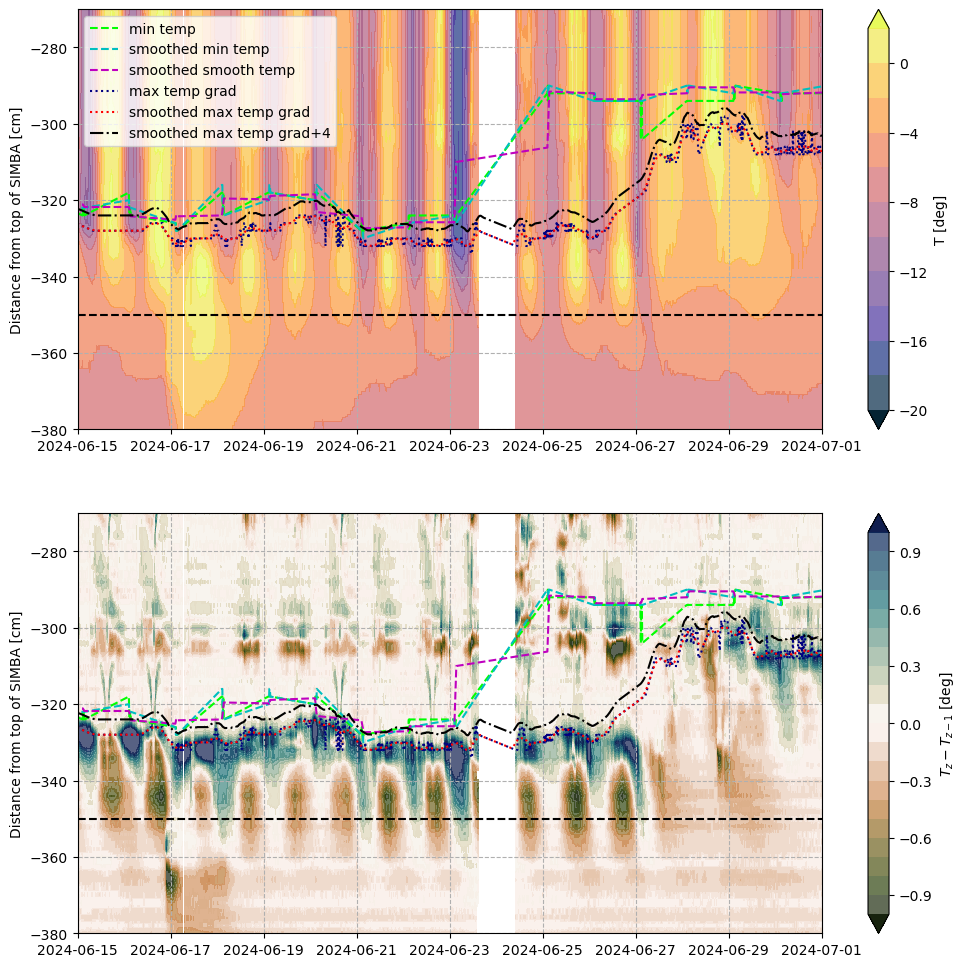

In [122]:

fig, axs = plt.subplots(2, figsize=(12,12), sharey=True)


cb = axs[0].contourf(season_data['dates'], season_data['height'], np.swapaxes(season_data['temperature'],0,1),
                cmap=cmocean.cm.thermal, levels=np.arange(-20,3,2), extend='both', alpha=.7)
plt.colorbar(cb, label='T [deg]', ax=axs[0])

cb = axs[1].contourf(season_data['dates'], season_data['height'][:-1], np.swapaxes(dTdz,0,1),
                cmap=cmocean.cm.tarn, levels=np.arange(-1,1.1,.1), extend='both', alpha=.7)
plt.colorbar(cb, label='$T_z-T_{z-1}$ [deg]', ax=axs[1])


axs[0].set_ylim(-380, -270) ## if you look at the full profile you can see when/where the surface accumulated along the rest of it

for ax in axs.ravel():
    ax.axhline(y=-350, c='k', ls='--') ## initial thermistor at the surface when the instrument was installed
    ax.plot(sfc_id_dates, sfc_id, c='lime', ls='--', label='min temp')
    ax.plot(sfc_id_dates, sfc_id_smoothed, c='c', ls='--', label='smoothed min temp')
    ax.plot(sfc_id_dates, sfc_id_smoothed_runmean, c='m', ls='--', label='smoothed smooth temp')
    ax.plot(season_data['dates'], sfc_maxTgrad, c='navy', ls=':', label='max temp grad')
    ax.plot(season_data['dates'], sfc_maxTgrad_smooth, c='red', ls=':', label='smoothed max temp grad')
    ax.plot(season_data['dates'], sfc_maxTgrad_smooth+4, c='k', ls='-.', label='smoothed max temp grad+4')

    ax.grid(ls='--')
    ax.set_ylabel('Distance from top of SIMBA [cm]')
    ax.set_xlim(datetime.datetime(2024,6,15), datetime.datetime(2024,7,25))

axs[0].legend(loc='upper left')
plt.show()

#### Next steps:
re-run retrieval w/ changing surface
go back to better quantify assumptions in retrieval and their impacts, specifically the assumption of small dT/dt=0!